In [1]:
import itertools

import numpy as np

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('classic')

from keras.models import Model
from keras.layers import Input, Dense, Convolution2D, Lambda, Activation
import keras.backend as K

Using TensorFlow backend.


In [0]:
def conv2d_transpose_layer_from_weights(weights, output_shape, strides):
  bias = K.variable(value=np.zeros(shape=output_shape))
  
  return Lambda(
    lambda x: 
      K.conv2d_transpose(x, weights, output_shape=output_shape, strides=strides) +
      bias
  )


def symmetric_conv_encoder_decoder(input_tensor, n_filters, kernel_size=(4,4), strides=(2,2), activation='relu', **kwargs):  
  
  input_shape = input_tensor.shape.as_list()
  encoder_layer = Convolution2D(n_filters, kernel_size=kernel_size, strides=strides, activation=activation, **kwargs)
   
  encoded = encoder_layer(input_tensor)
  weights = encoder_layer.weights[0]
  
  encoded_shape = encoded.shape.as_list()
  decoder_input = Input(batch_shape=encoded_shape)
  decoder_layer = conv2d_transpose_layer_from_weights(weights, input_shape, strides)
  reconstruction = Activation(activation)(
      decoder_layer(decoder_input)
  )
  
  encoder = Model(input_tensor, encoded)
  decoder = Model(decoder_input, reconstruction)
  
  return encoder, decoder


def compose_symmetric_conv_autoencoder(encoder, decoder):
  return Model(encoder.input, decoder(encoder.output))

## Load Olivetti faces

In [0]:
data_obj = fetch_olivetti_faces()

X = data_obj['data'].reshape(-1, 64, 64, 1)
y = data_obj['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=48, random_state=0)

In [0]:
batch_size = 48
steps_per_epoch = X_train.shape[0] // batch_size

X_train_batch_list = [X_train[i * batch_size: (i+1) * batch_size] for i in range(steps_per_epoch)]

X_train_batches = list(zip(X_train_batch_list, X_train_batch_list))

X_train_batch_gen = itertools.cycle(X_train_batches)

## Setup model

In [0]:
image_shape = X.shape[1:]

n_filters = 4

input_image = Input(batch_shape=(batch_size, *image_shape))
encoder, decoder = symmetric_conv_encoder_decoder(
    input_image,
    n_filters,
    activation='sigmoid'
)

In [0]:
autoencoder = compose_symmetric_conv_autoencoder(encoder, decoder)

In [0]:
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')


In [8]:
%%time

history = autoencoder.fit_generator(
    X_train_batch_gen,
    validation_data=(X_test, X_test),
    epochs=250,
    steps_per_epoch=steps_per_epoch,
    verbose=0
)

CPU times: user 10.3 s, sys: 2.66 s, total: 13 s
Wall time: 11 s


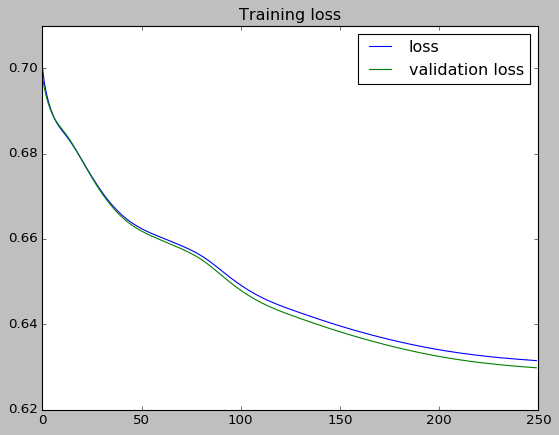

In [9]:
plt.title('Training loss')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

In [0]:
X_test_reconstructed = autoencoder.predict_on_batch(X_test)

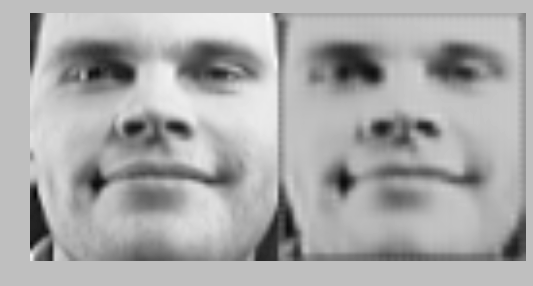

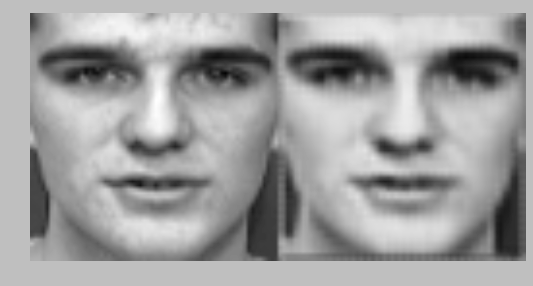

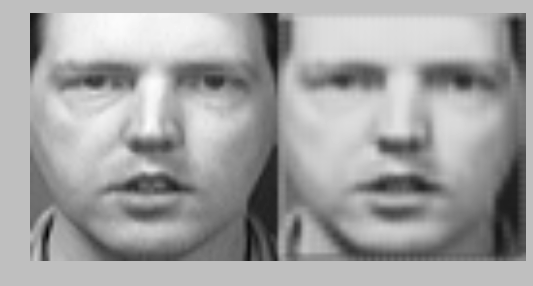

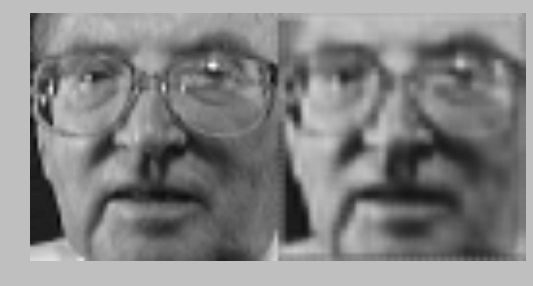

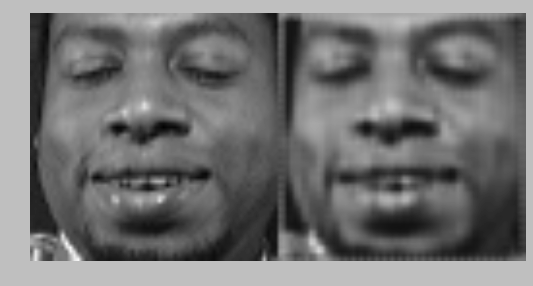

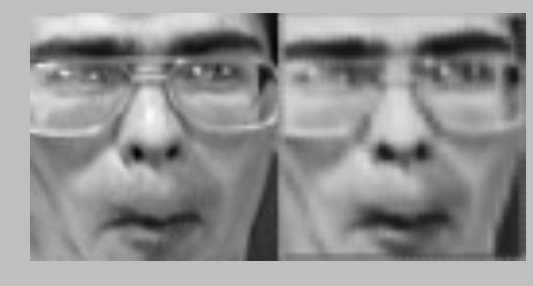

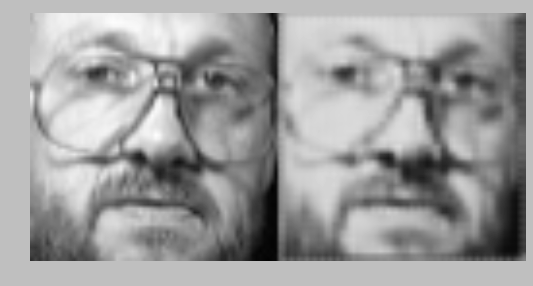

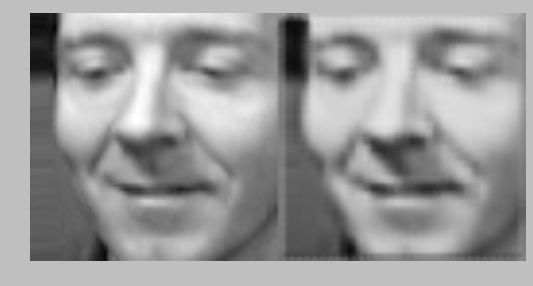

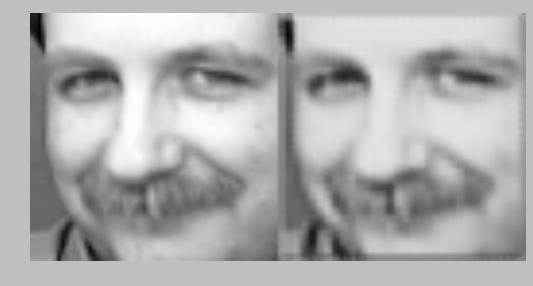

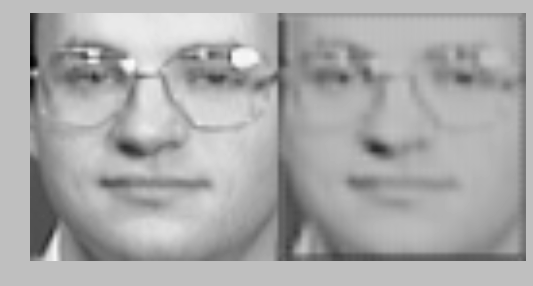

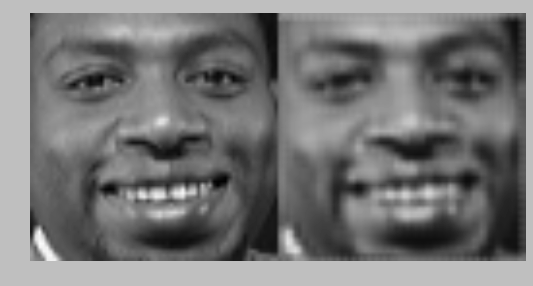

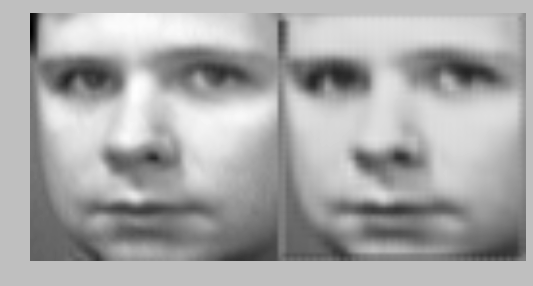

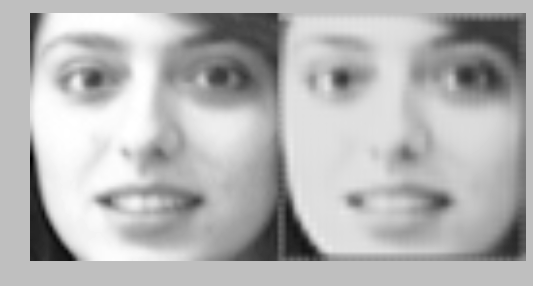

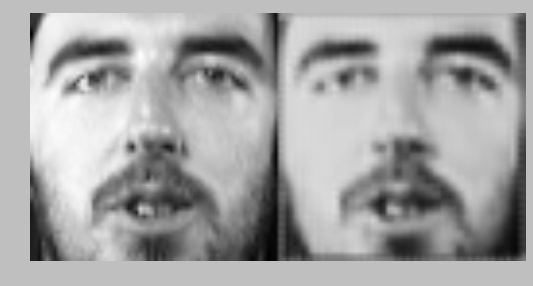

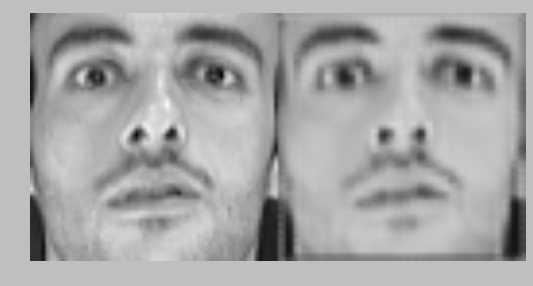

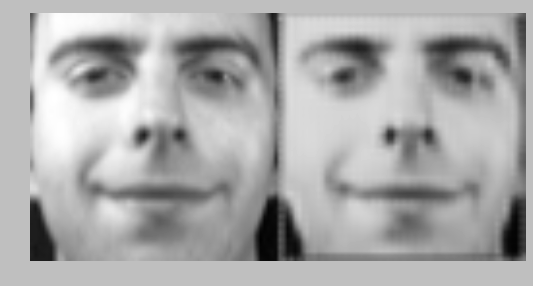

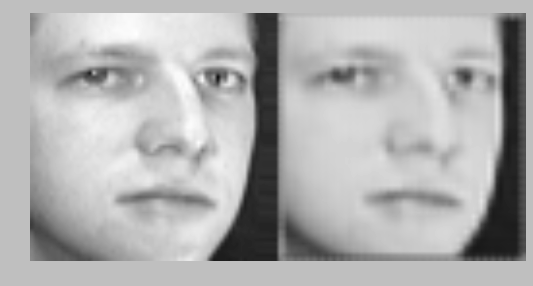

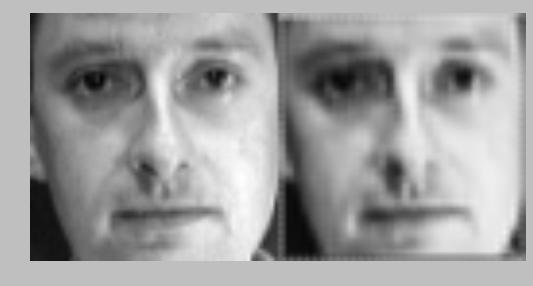

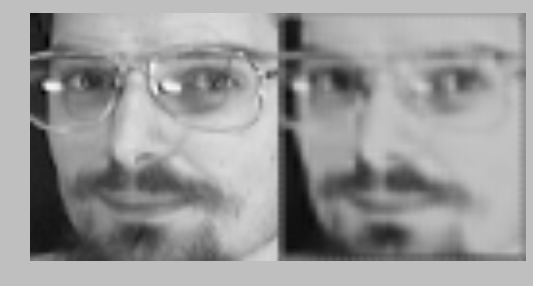

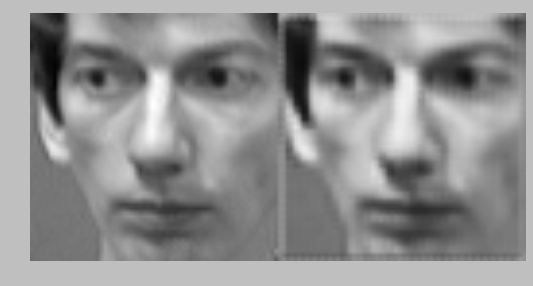

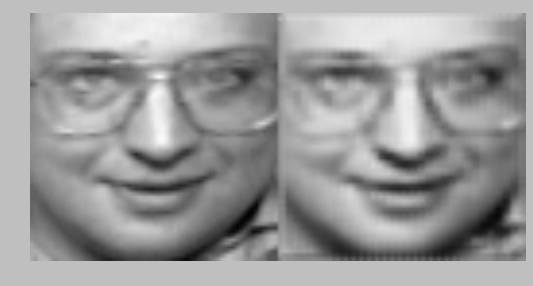

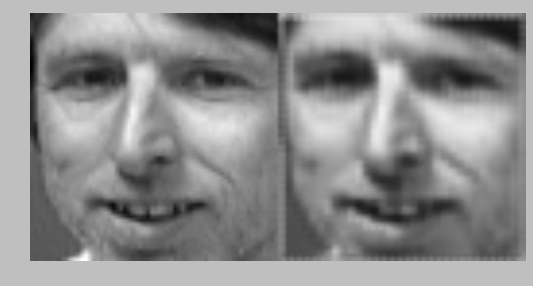

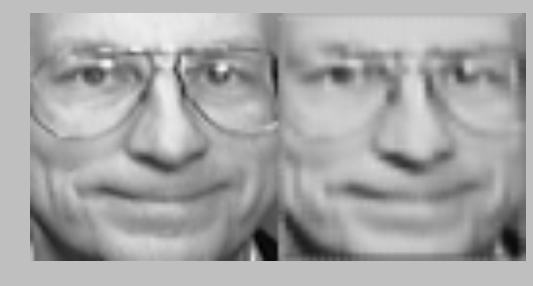

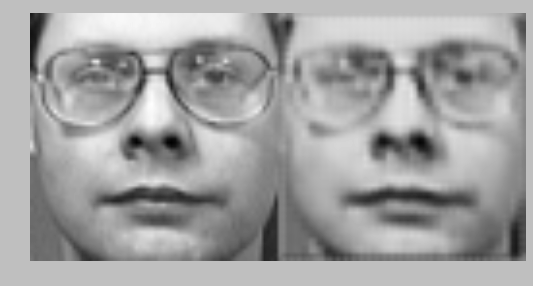

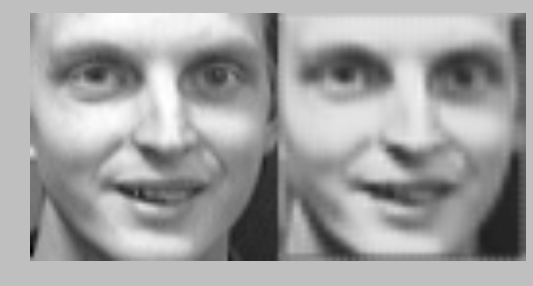

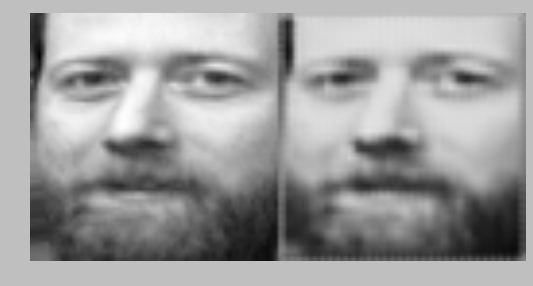

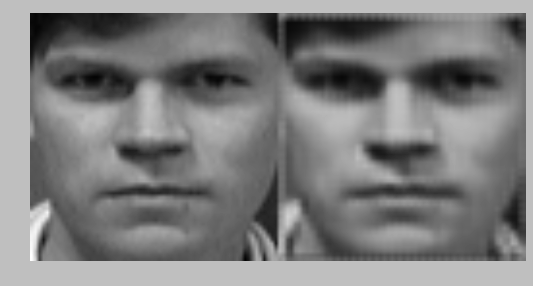

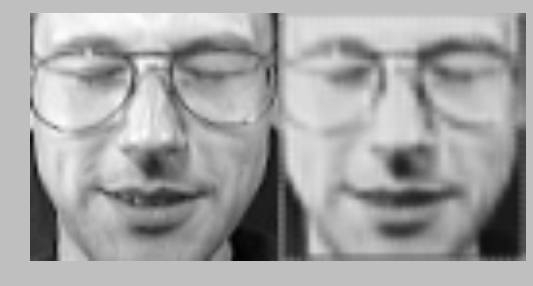

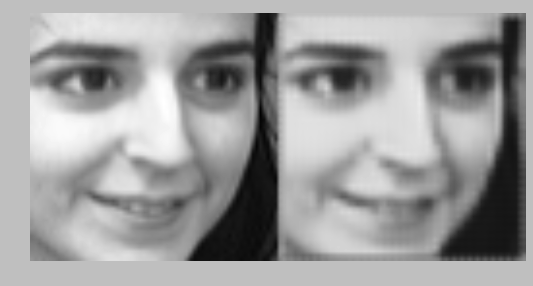

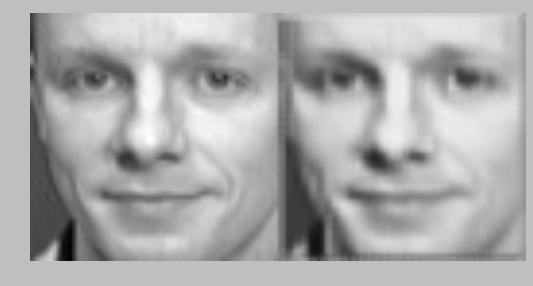

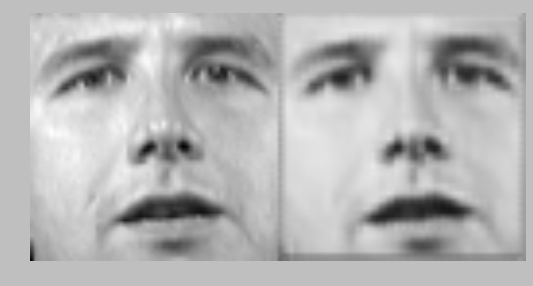

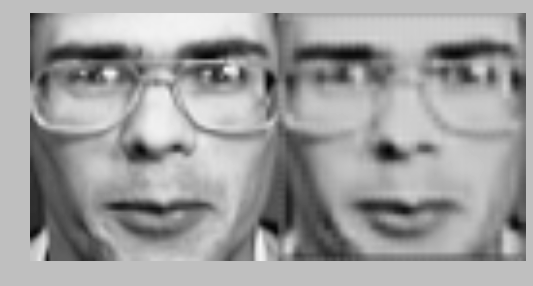

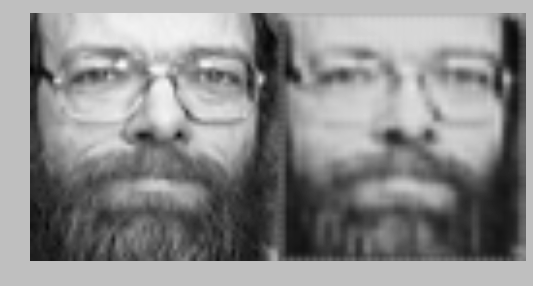

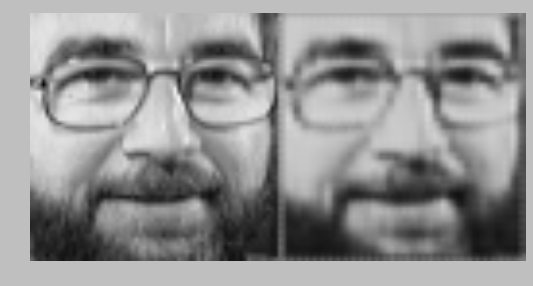

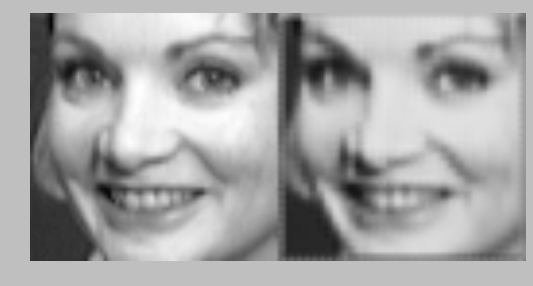

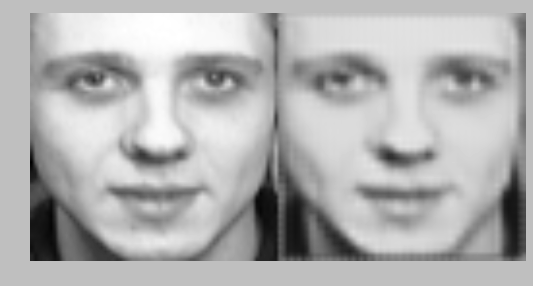

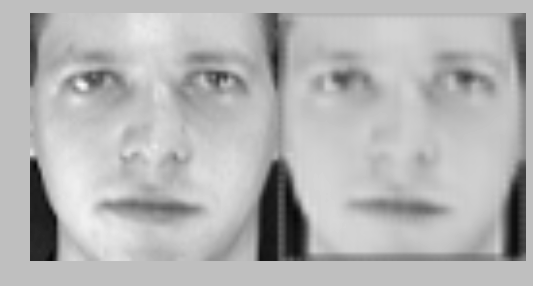

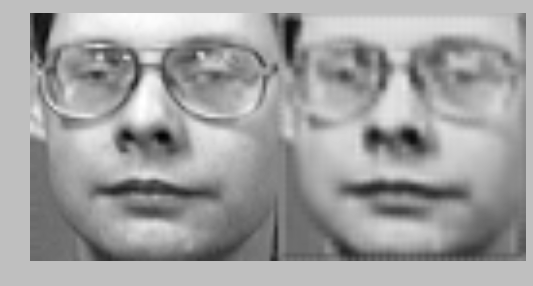

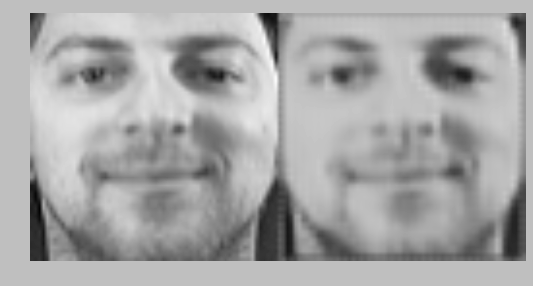

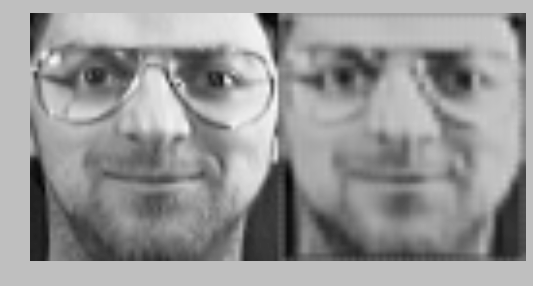

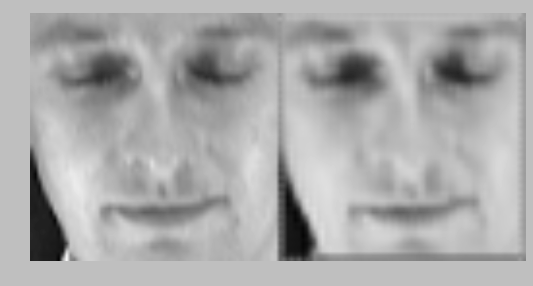

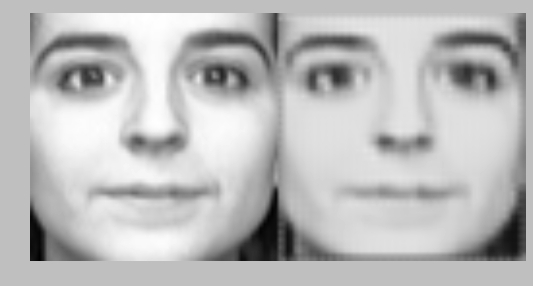

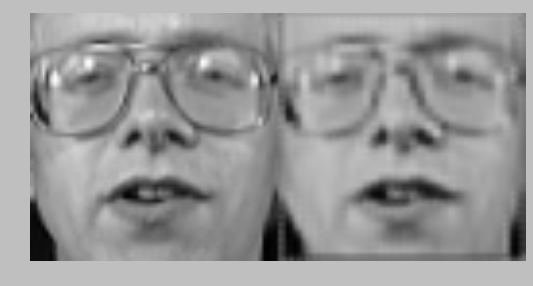

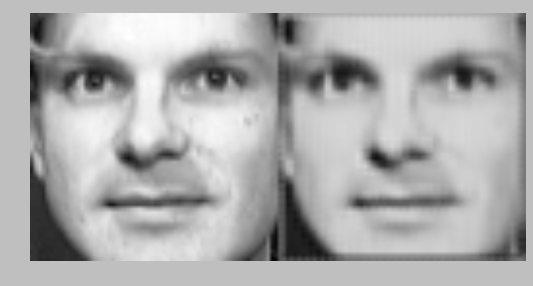

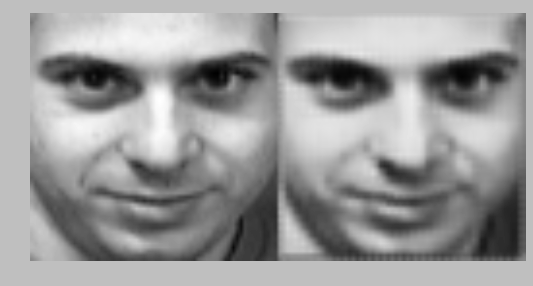

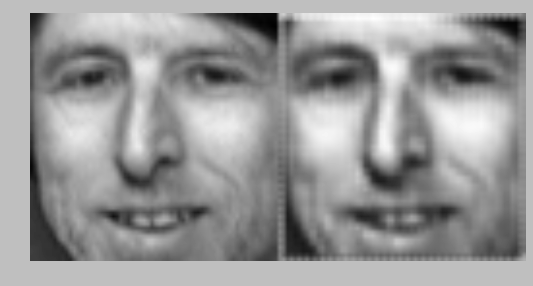

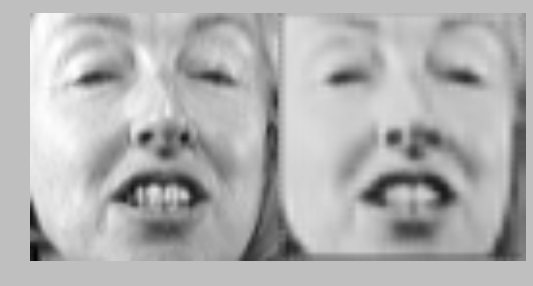

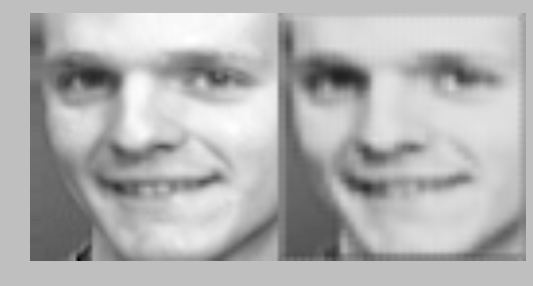

In [11]:
for img, reconstruction in zip(X_test, X_test_reconstructed):
  plt.imshow(np.hstack([img[:, :, 0] ,reconstruction[:, :, 0]]), cmap='gray')
  plt.axis('off')
  plt.show()